# Ejemplo 5.2: Convección-Difusión 1D con Esquema Upwind (UDS)
 
Este notebook resuelve el mismo problema de convección-difusión del Ejemplo 5.1, pero utilizando el **Esquema de Diferencias Contra-Corriente (Upwind Differencing Scheme - UDS)**.

### El Esquema Upwind

El UDS es un método alternativo para discretizar el término de convección. Su principal característica es que es un esquema "de un solo lado" o "contra-corriente": el valor de la propiedad $\phi$ en una cara de la celda se toma del nodo que se encuentra **corriente arriba** (upwind).

**Ventajas y Desventajas:**
- **Estabilidad Incondicional:** A diferencia del CDS, el UDS es estable para cualquier velocidad de flujo y tamaño de malla (es decir, para cualquier Número de Péclet). Nunca produce oscilaciones no físicas.
- **Difusión Numérica:** Su principal desventaja es que es formalmente de **primer orden de precisión**. Esto introduce un error numérico que actúa como una difusión artificial, conocido como **difusión numérica**. Este error tiende a "emborronar" o "difuminar" los gradientes pronunciados en la solución.

### Planteamiento del Problema

Se resuelve la misma ecuación gobernante con los mismos datos y solución analítica que en el ejemplo anterior para poder comparar directamente los resultados del UDS con los del CDS.

**Ecuación Gobernante:**
$$ \frac{d}{dx}(\rho u \phi) = \frac{d}{dx}\left(\Gamma\frac{d\phi}{dx}\right) $$

**Datos:**
- Longitud, $L = 1.0 \, m$
- Densidad, $\rho = 1.0 \, kg/m^3$
- Coeficiente de difusión, $\Gamma = 0.1 \, kg/(m \cdot s)$
- Condiciones de frontera: $\phi(0) = 1$ y $\phi(L) = 0$.

**Solución Analítica:**
$$ \frac{\phi - \phi_0}{\phi_L - \phi_0} = \frac{e^{(\rho u x / \Gamma)} - 1}{e^{(\rho u L / \Gamma)} - 1} $$


In [1]:
from mnspy import Vertice, Celda, Superficie, VolumenFinito, SuperficieDirichlet, Metodo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Caso 1: Flujo de baja velocidad (Pe = 0.2)
 
Se analiza el caso con una velocidad baja, $u = 0.1 \, m/s$, y una malla de 5 celdas.

### --- Configuración del Problema ---

In [2]:
L = 1.0
n_celdas = 5
phi_0 = 1
phi_L = 0
delta_x = L / n_celdas
Gamma = 0.1
A = 1
dens = 1.0
u = [0.1, 0.0, 0.0]

### --- Discretización ---

In [3]:
v = [Vertice(str(i), i*delta_x) for i in range(n_celdas + 1)]
s = [SuperficieDirichlet('0',[0], {'T': phi_0}, A,u=u)]
for i in range(1, n_celdas):
    s.append(Superficie(str(i),[i], A,u=u))
s.append(SuperficieDirichlet(str(n_celdas),[n_celdas], {'T': phi_L}, A,u=u))
c = [Celda(str(i+1),[i,i+1], gamma=Gamma,densidad=dens) for i in range(n_celdas)]

### --- Solución ---

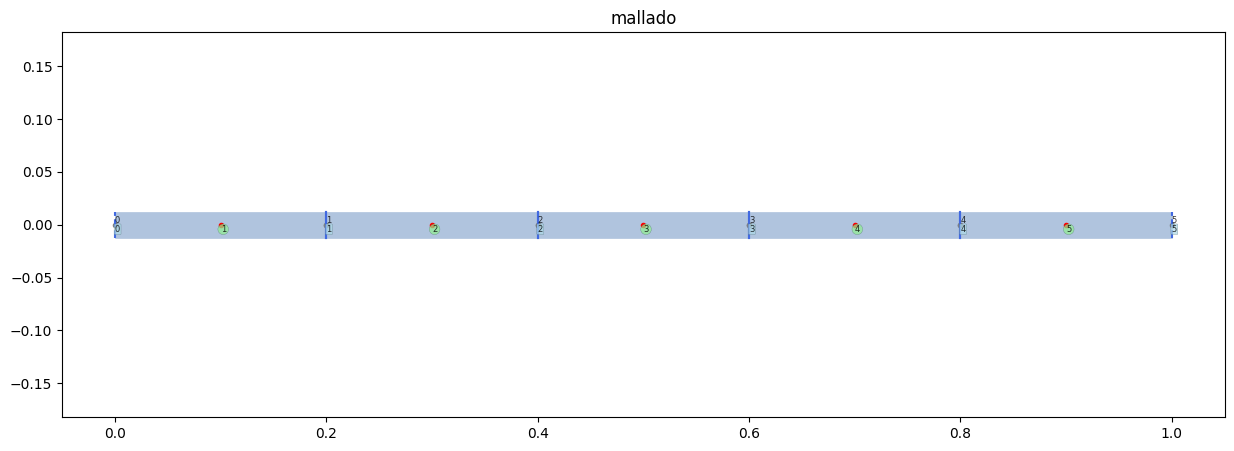

In [4]:
# Se especifica el método Upwind (UDS) al crear la instancia de VolumenFinito.
vol = VolumenFinito(v,s,c, metodo=Metodo.UDS)
vol.mallado()

In [5]:
vol.solucionar_por_Gauss()

## Análisis de Resultados (Caso 1)
### --- Post-procesamiento y Comparación ---

In [6]:
# Función para la solución analítica
def phi_analitica(x, rho, u, Gamma, L, phi_0, phi_L):
    numer = np.exp(rho * u * x / Gamma) - 1
    denom = np.exp(rho * u * L / Gamma) - 1
    if np.isclose(denom, 0): return phi_0 + (phi_L - phi_0) * x / L
    return phi_0 + (phi_L - phi_0) * numer / denom

# Tabla comparativa
x_numeric = np.array([celda.centroide.x for celda in vol.celdas])
phi_numeric = vol.get_solucion().flatten()

datos = {'Distancia': x_numeric, 'Solución FVM (UDS)': phi_numeric}
tabla = pd.DataFrame(datos, index = [c.nombre for c in vol.celdas])
tabla.index.name='Celda'
tabla['Solución Analítica'] = phi_analitica(x_numeric, dens, u[0], Gamma, L, phi_0, phi_L)
tabla['Error Absoluto'] = tabla['Solución Analítica'] - tabla['Solución FVM (UDS)']
tabla['% Error Relativo'] = (100 * np.abs(tabla['Error Absoluto'] / tabla['Solución Analítica'])).map('{:.2f}%'.format)
tabla

,Distancia,Solución FVM (UDS),Solución Analítica,Error Absoluto,% Error Relativo
Celda,,,,,
1,0.1,0.933733,0.938793,0.005060,0.54%
2,0.3,0.787947,0.796390,0.008443,1.06%
3,0.5,0.613003,0.622459,0.009456,1.52%
4,0.7,0.403071,0.410020,0.006949,1.69%
5,0.9,0.151151,0.150545,-0.000606,0.40%


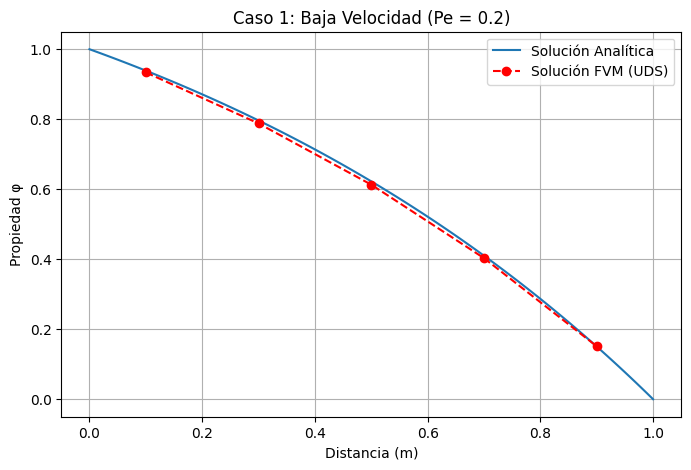

In [7]:
# Gráfica comparativa
x_analytic = np.linspace(0, L, 100)
y_analytic = phi_analitica(x_analytic, dens, u[0], Gamma, L, phi_0, phi_L)

plt.figure(figsize=(8,5))
plt.plot(x_analytic, y_analytic, label='Solución Analítica')
plt.plot(x_numeric, phi_numeric, 'o--', c='r', label='Solución FVM (UDS)')
plt.legend()
plt.grid()
plt.title('Caso 1: Baja Velocidad (Pe = 0.2)')
plt.xlabel('Distancia (m)')
plt.ylabel('Propiedad φ')
plt.show()

**Conclusión (Caso 1):** Para un Péclet bajo, el esquema UDS es estable, pero la tabla de errores muestra que es **menos preciso** que el esquema CDS (visto en el ejemplo anterior). Este error adicional es la difusión numérica.

## Caso 2: Flujo de alta velocidad (Pe = 5.0)
 
Ahora se aumenta la velocidad a $u = 2.5 \, m/s$ con la misma malla de 5 celdas. En estas condiciones, el esquema CDS falló y produjo oscilaciones.

### --- Configuración y Solución ---

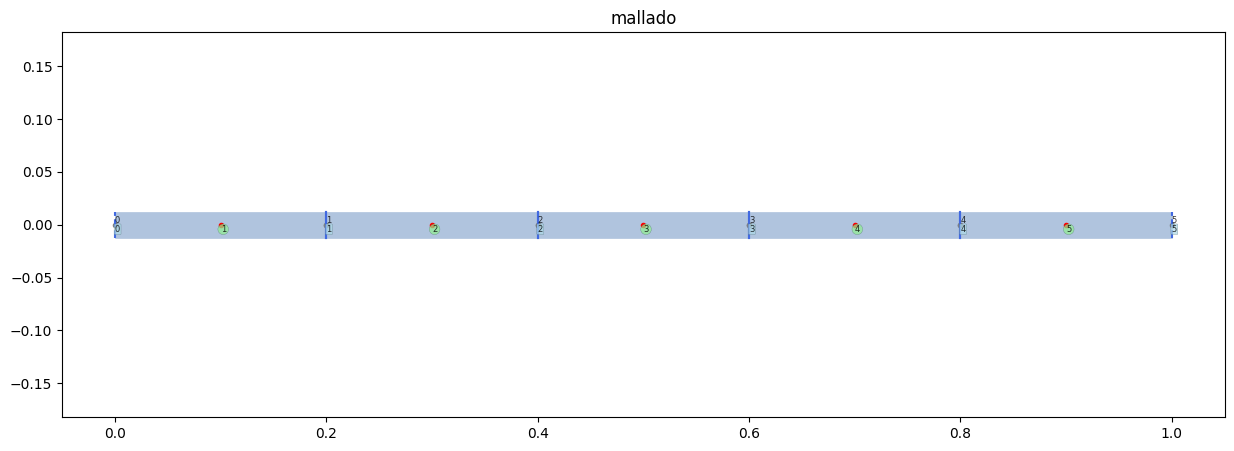

In [8]:
u = [2.5, 0.0, 0.0]

v = [Vertice(str(i), i*delta_x) for i in range(n_celdas + 1)]
s = [SuperficieDirichlet('0',[0], {'T': phi_0}, A,u=u)]
for i in range(1, n_celdas):
    s.append(Superficie(str(i),[i], A,u=u))
s.append(SuperficieDirichlet(str(n_celdas),[n_celdas], {'T': phi_L}, A,u=u))
c = [Celda(str(i+1),[i,i+1], gamma=Gamma,densidad=dens) for i in range(n_celdas)]

vol = VolumenFinito(v,s,c, metodo=Metodo.UDS)
vol.mallado()

In [9]:
vol.solucionar_por_Gauss()

## Análisis de Resultados (Caso 2)
### --- Post-procesamiento y Comparación ---

In [10]:
x_numeric = np.array([celda.centroide.x for celda in vol.celdas])
phi_numeric = vol.get_solucion().flatten()

datos = {'Distancia': x_numeric, 'Solución FVM (UDS)': phi_numeric}
tabla = pd.DataFrame(datos, index = [c.nombre for c in vol.celdas])
tabla.index.name='Celda'
tabla['Solución Analítica'] = phi_analitica(x_numeric, dens, u[0], Gamma, L, phi_0, phi_L)
tabla['Error Absoluto'] = tabla['Solución Analítica'] - tabla['Solución FVM (UDS)']
tabla['% Error Relativo'] = (100 * np.abs(tabla['Error Absoluto'] / tabla['Solución Analítica'])).map('{:.2f}%'.format)
tabla

,Distancia,Solución FVM (UDS),Solución Analítica,Error Absoluto,% Error Relativo
Celda,,,,,
1,0.1,0.999843,1.000000,0.000157,0.02%
2,0.3,0.998740,1.000000,0.001260,0.13%
3,0.5,0.992126,0.999996,0.007870,0.79%
4,0.7,0.952441,0.999447,0.047006,4.70%
5,0.9,0.714331,0.917915,0.203584,22.18%


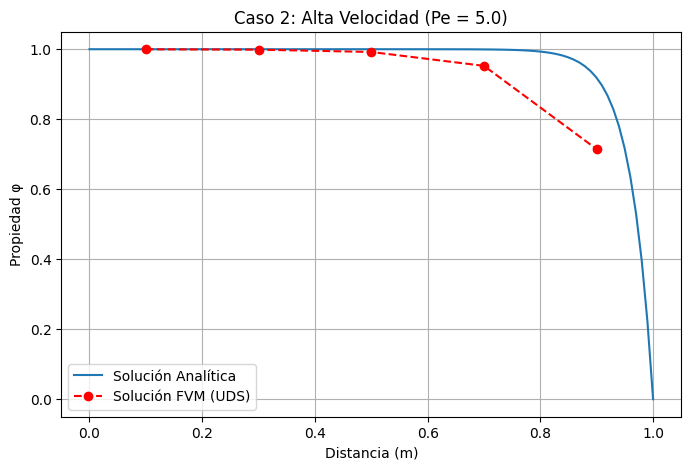

In [11]:
x_analytic = np.linspace(0, L, 100)
y_analytic = phi_analitica(x_analytic, dens, u[0], Gamma, L, phi_0, phi_L)

plt.figure(figsize=(8,5))
plt.plot(x_analytic, y_analytic, label='Solución Analítica')
plt.plot(x_numeric, phi_numeric, 'o--', c='r', label='Solución FVM (UDS)')
plt.legend()
plt.grid()
plt.title('Caso 2: Alta Velocidad (Pe = 5.0)')
plt.xlabel('Distancia (m)')
plt.ylabel('Propiedad φ')
plt.show()

**Conclusión (Caso 2):** El esquema UDS produce una solución **estable y físicamente realista**, sin las oscilaciones del CDS. Sin embargo, la tabla de errores y la gráfica muestran claramente el efecto de la **difusión numérica**: la solución está "emborronada" y tiene un error significativo en comparación con la solución analítica.

## Conclusiones Generales: UDS vs. CDS
 
 La comparación de los Ejemplos 5.1 y 5.2 ilustra un dilema fundamental en la Dinámica de Fluidos Computacional (CFD):
 
 1.  **Esquema de Diferencias Centradas (CDS):**
     - **Precisión:** Formalmente de segundo orden, muy preciso cuando es estable (Pe < 2).
     - **Estabilidad:** Condicionalmente estable. Falla catastróficamente (oscilaciones) en flujos dominados por convección (Pe > 2), a menos que la malla sea muy fina.
 
 2.  **Esquema Upwind (UDS):**
     - **Precisión:** Formalmente de primer orden. Introduce difusión numérica, lo que lo hace menos preciso que el CDS, especialmente en mallas gruesas.
     - **Estabilidad:** Incondicionalmente estable. Siempre produce una solución físicamente posible, sin importar el Número de Péclet.
 
 **El Trade-Off:**
 El UDS sacrifica la precisión para garantizar la estabilidad. Es un método robusto y simple, pero su difusión numérica puede ser un problema grave en simulaciones prácticas. Esto ha motivado el desarrollo de esquemas de orden superior (como QUICK, TVD, etc.) que buscan combinar la estabilidad del UDS con la precisión del CDS.